
Loading dataset from D:\Fraud Detection\Fraud.csv...
Loaded 6,362,620 transactions.

Starting Exploratory Data Analysis (EDA)...
 -> Analyzing Fraud by Transaction Type...
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


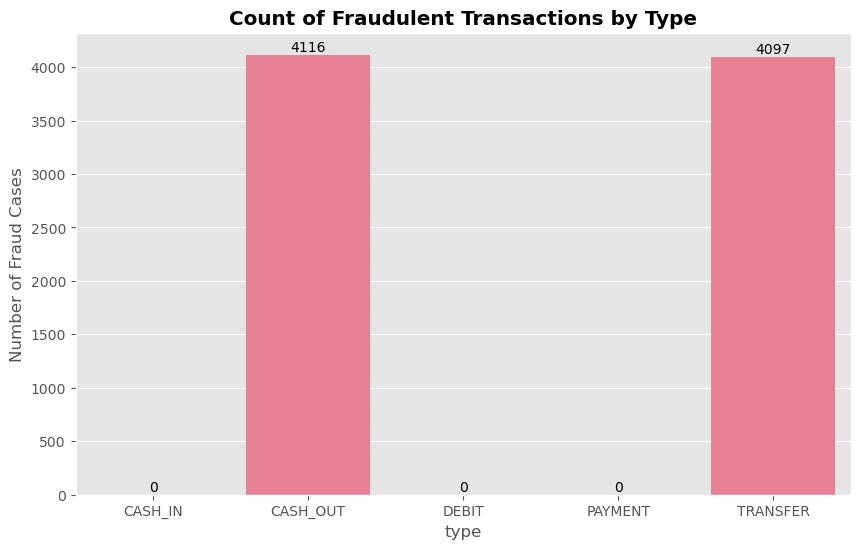


 -> Class Imbalance:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
 -> Fraud Rate: 0.1291%

Preprocessing and Feature Engineering...
 -> Filtered dataset to 2770409 rows (TRANSFER & CASH_OUT only).
 -> Engineering complete. Features used: ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'errorBalanceOrig', 'errorBalanceDest']

Data Split: Train shape (2216327, 8), Test shape (554082, 8)

Training XGBoost Model...
   -> Training Complete.

Evaluating Model Performance...

 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.88      1.00      0.94      1643

    accuracy                           1.00    554082
   macro avg       0.94      1.00      0.97    554082
weighted avg       1.00      1.00      1.00    554082

Area Under Precision-Recall Curve (AUPRC): 0.9903


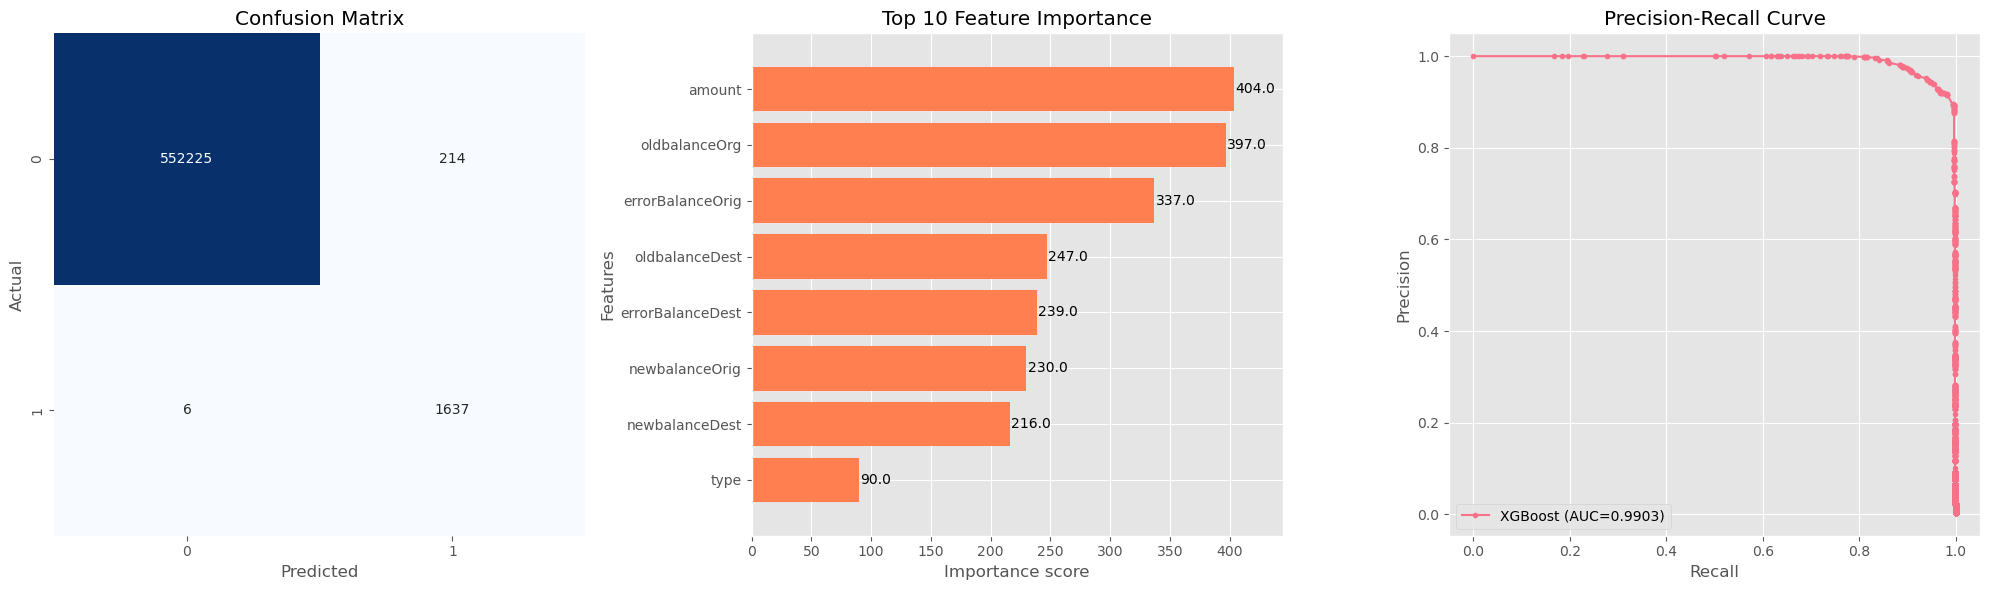

In [9]:
# 1. LIBRARIES & CONFIGURATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (average_precision_score, classification_report, 
                             confusion_matrix, precision_recall_curve, roc_auc_score)
from sklearn.preprocessing import LabelEncoder
import warnings
import gc

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("husl")
RANDOM_SEED = 42

class FraudDetector:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None

    def load_data(self):
        """Loads data and performs initial type optimization to save memory."""
        print(f"\nLoading dataset from {self.filepath}...")
        try:
            self.df = pd.read_csv(self.filepath)
            print(f"Loaded {self.df.shape[0]:,} transactions.")
        except FileNotFoundError:
            print("File not found. Please check the path.")
            raise

    def perform_eda(self):
        """Generates key insights and visualizations."""
        print("\nStarting Exploratory Data Analysis (EDA)...")
        
        # Insight 1: Fraud by Transaction Type
        print(" -> Analyzing Fraud by Transaction Type...")
        type_group = self.df.groupby('type')['isFraud'].sum()
        print(type_group)
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=type_group.index, y=type_group.values)
        plt.title('Count of Fraudulent Transactions by Type', fontweight='bold')
        plt.ylabel('Number of Fraud Cases')
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom')
        plt.show()

        # Insight 2: Class Imbalance
        fraud_count = self.df['isFraud'].value_counts()
        print(f"\n -> Class Imbalance:\n{fraud_count}")
        print(f" -> Fraud Rate: {self.df['isFraud'].mean()*100:.4f}%")

    def preprocess_and_feature_engineering(self):
        print("\nPreprocessing and Feature Engineering...")
        
        # 1. FILTERING
        valid_types = ['TRANSFER', 'CASH_OUT']
        self.df = self.df[self.df['type'].isin(valid_types)].copy()
        print(f" -> Filtered dataset to {len(self.df)} rows (TRANSFER & CASH_OUT only).")

        # 2. FEATURE ENGINEERING
        # ErrorBalance: The difference between the amount sent and the actual change in balance.
        # Fraudsters often manipulate the system so the balance change doesn't match the amount.
        self.df['errorBalanceOrig'] = self.df['newbalanceOrig'] + self.df['amount'] - self.df['oldbalanceOrg']
        self.df['errorBalanceDest'] = self.df['oldbalanceDest'] + self.df['amount'] - self.df['newbalanceDest']

        # Label Encoding for 'type'
        le = LabelEncoder()
        self.df['type'] = le.fit_transform(self.df['type'])

        drop_cols = ['step', 'nameOrig', 'nameDest', 'isFlaggedFraud']
        self.df = self.df.drop(columns=drop_cols)
        
        print(" -> Engineering complete. Features used:", self.df.columns.tolist())

    def split_data(self):
        """Splits data into Training and Testing sets."""
        X = self.df.drop('isFraud', axis=1)
        y = self.df['isFraud']

        # Using Stratified Split to maintain the tiny percentage of fraud in both sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
        )
        print(f"\nData Split: Train shape {self.X_train.shape}, Test shape {self.X_test.shape}")
        
        # Garbage collection to free memory
        del self.df
        gc.collect()

    def train_model(self):
            """Trains an XGBoost Classifier with handling for class imbalance."""
            print("\nTraining XGBoost Model...")
            
            # Calculate scale_pos_weight to handle imbalance
            # (Negative Cases / Positive Cases)
            weights = (self.y_train == 0).sum() / (self.y_train == 1).sum()
            
            self.model = xgb.XGBClassifier(
                n_estimators=1000,           
                max_depth=6,                 
                learning_rate=0.05,          
                subsample=0.8,               
                colsample_bytree=0.8,        
                scale_pos_weight=weights,    
                random_state=RANDOM_SEED,
                n_jobs=-1,
                tree_method='hist',          
                # NEW LOCATION FOR EVAL METRICS:
                eval_metric='aucpr',         
                early_stopping_rounds=50     
            )
    
            self.model.fit(
                self.X_train, self.y_train,
                eval_set=[(self.X_test, self.y_test)],
                verbose=False
            )
            print("   -> Training Complete.")

    def evaluate_model(self):
        """Comprehensive evaluation metrics and visualizations."""
        print("\nEvaluating Model Performance...")
        
        # Predictions
        y_pred = self.model.predict(self.X_test)
        y_prob = self.model.predict_proba(self.X_test)[:, 1]

        # 1. Classification Report
        print("\n CLASSIFICATION REPORT")
        print(classification_report(self.y_test, y_pred))

        # 2. AUPRC (The Gold Standard for Imbalanced Data)
        auprc = average_precision_score(self.y_test, y_prob)
        print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

        # 3. Visualizations
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')

        # Feature Importance
        xgb.plot_importance(self.model, importance_type='weight', max_num_features=10, 
                           height=0.8, ax=axes[1], color='coral')
        axes[1].set_title('Top 10 Feature Importance')

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_prob)
        axes[2].plot(recall, precision, marker='.', label=f'XGBoost (AUC={auprc:.4f})')
        axes[2].set_xlabel('Recall')
        axes[2].set_ylabel('Precision')
        axes[2].set_title('Precision-Recall Curve')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # EXECUTION PIPELINE
    
    DATA_PATH = r"D:\Fraud Detection\Fraud.csv"
    
    detector = FraudDetector(DATA_PATH)
    
    # Run Pipeline
    detector.load_data()
    detector.perform_eda()
    detector.preprocess_and_feature_engineering()
    detector.split_data()
    detector.train_model()
    detector.evaluate_model()